<a href="https://colab.research.google.com/github/tripatheea/transform/blob/main/weights_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy import interpolate
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers
from sklearn.model_selection import train_test_split

In [3]:
path = '/content/drive/MyDrive/transform//'

# data = np.load(f'{path}/depth_86_bigger.npz')

data = np.load(f'{path}/depth_1_injs.npz')

In [4]:
all_x, all_y = data['x'], data['y']

In [5]:
all_x.shape

(2500, 10, 47, 4)

In [112]:
shuffle = True

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(all_x, all_y, test_size=0.1, random_state=42, shuffle=shuffle)
x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=42, shuffle=shuffle)

x_train_s.shape, x_test_s.shape, x_val_s.shape

((2250, 10, 47, 4), (125, 10, 47, 4), (125, 10, 47, 4))

In [113]:
x_train_s.shape

(2250, 10, 47, 4)

In [114]:
all_train_metrics = {'loss': [], 'accuracy': [], 'p_det': []}
all_val_metrics = {'loss': [], 'accuracy': [], 'p_det': []}
all_test_p_dets = []
all_test_fpr_s = []
all_test_tpr_s = []

In [134]:
def get_p_det_metric(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return np.interp(0.01, fpr, tpr)
    
def p_det(y_true, y_pred): 
    return tf.numpy_function(get_p_det_metric, (y_true, y_pred), tf.double)

def get_model():
    act = 'relu'

    reg = tf.keras.regularizers.L2(
        l2=0.0000000000001)

    input = tf.keras.Input(shape=(all_x.shape[1], all_x.shape[2], all_x.shape[3],))
    x_layer = tf.keras.layers.Conv1D(filters=4, kernel_size=1, strides=1, groups=2, kernel_regularizer=reg, activation=act, kernel_initializer='he_normal')(input)
    x_layer = tf.keras.layers.Conv2D(filters=4, kernel_size=(2, 4), kernel_regularizer=reg, strides=(1, 2), activation=act, kernel_initializer='he_normal')(x_layer)
    x_layer = tf.keras.layers.Flatten()(x_layer)
    x_layer = tf.keras.layers.Dense(32, activation=act, kernel_regularizer=reg, kernel_initializer='he_normal')(x_layer)
    x_layer = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x_layer)

    tf_model = tf.keras.Model(inputs=input, outputs=x_layer)

    return tf_model

tf_model = get_model()

In [135]:
tf_model.compile(
                optimizer='adam',
                 loss='binary_crossentropy',
              metrics=['accuracy', p_det],
                )

tf_model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 10, 47, 4)]       0         
                                                                 
 conv1d_26 (Conv1D)          (None, 10, 47, 4)         12        
                                                                 
 conv2d_21 (Conv2D)          (None, 9, 22, 4)          132       
                                                                 
 flatten_21 (Flatten)        (None, 792)               0         
                                                                 
 dense_45 (Dense)            (None, 32)                25376     
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 25,553
Trainable params: 25,553
Non-trainabl

In [136]:
EPOCHS = 10


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=f"{path}/" + "weights/weights.epoch_{epoch:02d}-val_p_det_{val_p_det:.2f}.hdf5",
                                save_weights_only=True,
                                monitor='val_p_det',
                                mode='max',
                                save_best_only=True,
                                save_freq='epoch',
                                verbose=False)

history = tf_model.fit(x_train_s, y_train_s, 
                        epochs=EPOCHS, 
                        validation_data=(x_val_s, y_val_s), 
                        callbacks=[model_checkpoint_callback]
                       )

# plot_history(history, test_dataset, x_test_s, y_test_s, title=f"Depth = {min_depth:.2f}, {max_depth:.2f}")

# # if br_idx_i > 0:
# model_path = path + '/saved_models'
# !mkdir -p model_path
# tf_model.save(model_path + f'/my_model_depths_{min_depth:.2f}_{max_depth:.2f}')

# break

Epoch 1/10
71/71 [==============================] - 5s 43ms/step - loss: 0.2662 - accuracy: 0.9644 - p_det: 0.9534 - val_loss: 0.0480 - val_accuracy: 1.0000 - val_p_det: 1.0000
Epoch 2/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0211 - accuracy: 0.9996 - p_det: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000 - val_p_det: 1.0000
Epoch 3/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0065 - accuracy: 1.0000 - p_det: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000 - val_p_det: 1.0000
Epoch 4/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0034 - accuracy: 1.0000 - p_det: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 - val_p_det: 1.0000
Epoch 5/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0021 - accuracy: 1.0000 - p_det: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000 - val_p_det: 1.0000
Epoch 6/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0014 - accuracy: 1.0000 - p_det: 1.0000 

4/4 [==============================] - 0s 9ms/step - loss: 6.8230e-04 - accuracy: 1.0000 - p_det: 1.0000


4/4 [==============================] - 0s 7ms/step


test p_det is 1.0000.




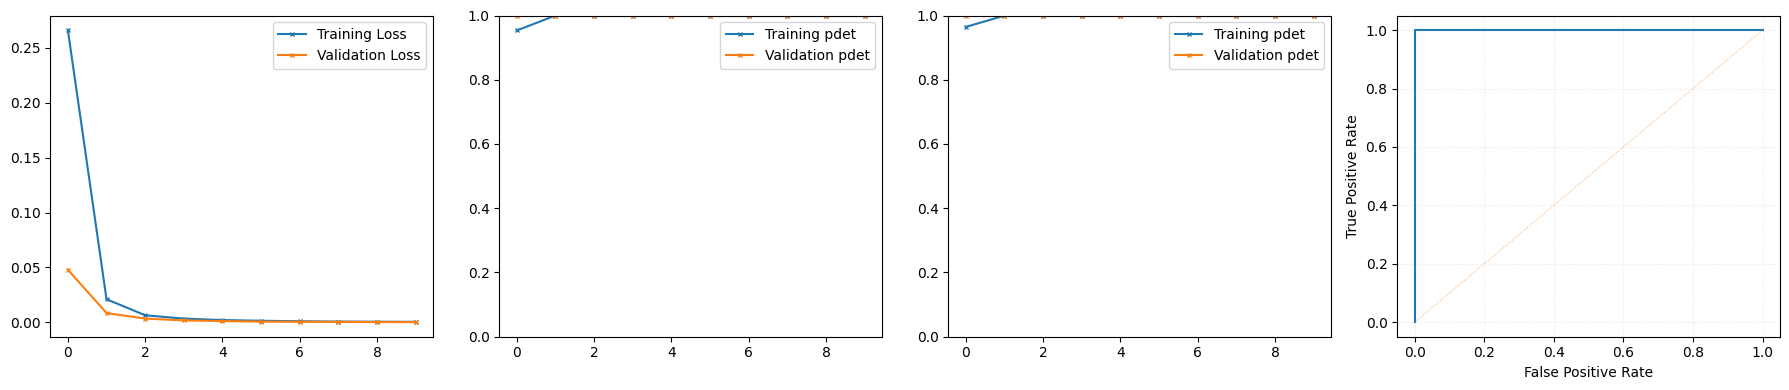

In [137]:
plt.figure(figsize=(18, 4))

plt.subplot(141)

plt.plot(history.history['loss'], label="Training Loss", marker="x", ms=3)
plt.plot(history.history['val_loss'], label="Validation Loss", marker="x", ms=3)

plt.legend()

plt.subplot(142)

metric = 'p_det'

plt.plot(history.history[metric], label="Training pdet", marker="x", ms=3)
plt.plot(history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

plt.ylim(0, 1)

plt.legend()

plt.subplot(143)

metric = 'accuracy'

plt.plot(history.history[metric], label="Training pdet", marker="x", ms=3)
plt.plot(history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

plt.ylim(0, 1)

plt.legend()


plt.subplot(144)
result = tf_model.evaluate(x_test_s, y_test_s)

test_predicted_ys = tf_model.predict(x_test_s)
fpr, tpr, thresholds = roc_curve(y_test_s, test_predicted_ys)

p_det = interpolate.interp1d(fpr, tpr)(0.01)

print(f"\n\ntest p_det is {p_det:.4f}.\n\n")

all_test_tpr_s.append(tpr)
all_test_fpr_s.append(fpr)
all_test_p_dets.append(p_det)


for m in ['loss', 'accuracy', 'p_det']:
    all_train_metrics[m].append(history.history[m])
    all_val_metrics[m].append(history.history['val_' + m])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="dotted", lw=0.5)
plt.grid(alpha=0.3, ls="dotted")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# plt.suptitle(title)

plt.tight_layout()

In [138]:
all_x.shape

(2500, 10, 47, 4)

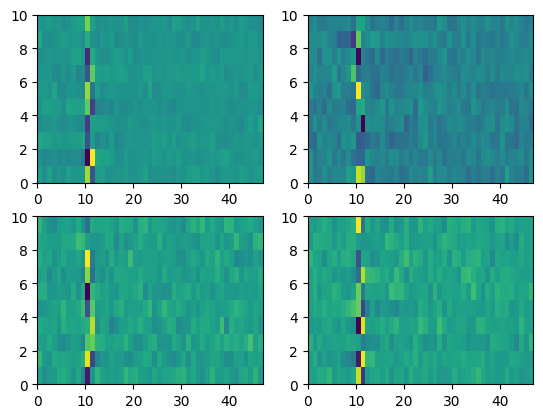

In [139]:
plt.subplot(221)
plt.pcolormesh(all_x[0,:,:,0])

plt.subplot(222)
plt.pcolormesh(all_x[0,:,:,1])

plt.subplot(223)
plt.pcolormesh(all_x[0,:,:,2])

plt.subplot(224)
plt.pcolormesh(all_x[0,:,:,3])

In [140]:
tf_model.layers

In [167]:
layer_1_weights, layer_1_biases = tf_model.layers[1].get_weights()

# (kernel_size, groups, n_filters)

layer_1_weights.shape, layer_1_biases.shape

((1, 2, 4), (4,))

In [168]:
w = [np.ones((1, 2, 4)), np.zeros(4,)]

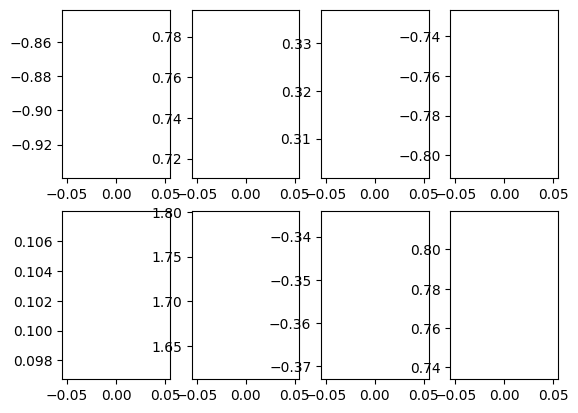

In [148]:
plt.subplot(241)
plt.plot(layer_1_weights[:,0,0])

plt.subplot(242)
plt.plot(layer_1_weights[:,0,1])

plt.subplot(243)
plt.plot(layer_1_weights[:,0,2])

plt.subplot(244)
plt.plot(layer_1_weights[:,0,3])



plt.subplot(245)
plt.plot(layer_1_weights[:,1,0])

plt.subplot(246)
plt.plot(layer_1_weights[:,1,1])

plt.subplot(247)
plt.plot(layer_1_weights[:,1,2])

plt.subplot(248)
plt.plot(layer_1_weights[:,1,3])

In [192]:
all_x.shape, x_train_s.shape, np.expand_dims(x_train_s[1,:,:,0], axis=[0, 3]).shape

((2500, 10, 47, 4), (2250, 10, 47, 4), (1, 10, 47, 1))

In [203]:
inp = tf.keras.Input(shape=(all_x.shape[1], all_x.shape[2], all_x.shape[3]))
x_la = tf.keras.layers.Conv1D(filters=1, kernel_size=1, weights=[np.ones((1, 4, 1)), np.zeros(1,)], activation='relu')(inp)

eval_mod = tf.keras.Model(inputs=inp, outputs=x_la)

# [np.ones((1, 1, 1)), np.zeros(1,)]

1/1 [==============================] - 0s 116ms/step
(1, 10, 47, 1)


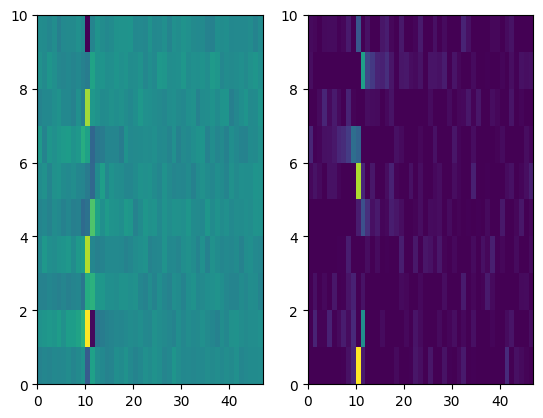

In [205]:
y_eval = eval_mod.predict(np.expand_dims(x_train_s[1,:,:,:], axis=0))

print(y_eval.shape)

plt.subplot(121)
plt.pcolormesh(x_train_s[1,:,:,0])

plt.subplot(122)
plt.pcolormesh(y_eval[0,:,:,0])

1/1 [==============================] - 0s 112ms/step
(1, 10, 47, 1)


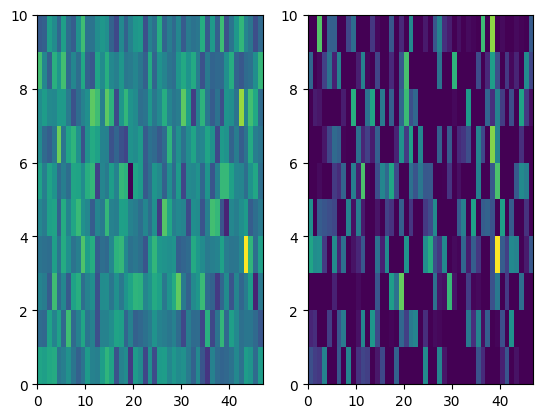

In [206]:
y_eval = eval_mod.predict(np.expand_dims(x_train_s[5,:,:,:], axis=0))

print(y_eval.shape)

plt.subplot(121)
plt.pcolormesh(x_train_s[5,:,:,0])

plt.subplot(122)
plt.pcolormesh(y_eval[0,:,:,0])

1/1 [==============================] - 0s 21ms/step
(1, 10, 47, 4)


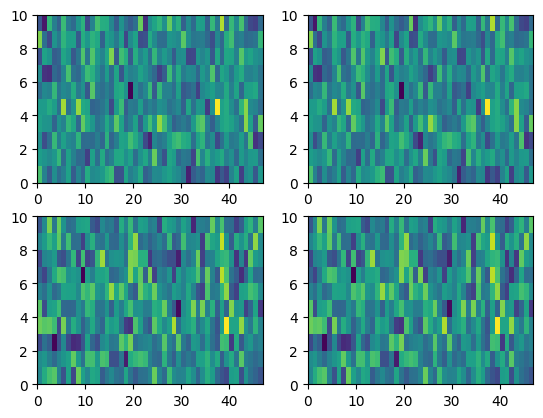

In [172]:
y_eval = eval_mod.predict(np.expand_dims(x_train_s[5], 0))

print(y_eval.shape)

plt.subplot(221)

plt.pcolormesh(y_eval[0,:,:,0])

plt.subplot(222)

plt.pcolormesh(y_eval[0,:,:,1])

plt.subplot(223)

plt.pcolormesh(y_eval[0,:,:,2])

plt.subplot(224)

plt.pcolormesh(y_eval[0,:,:,3])

In [185]:
y_train_s

array([0., 1., 1., ..., 1., 1., 1.])